In [40]:
import copy
import os
import re
import shutil
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile
import yaml
from einops import rearrange, repeat
from ome_types import from_xml

Note: the serial sections used in this tutorial have been downsampled for sake of the tutorial to 1-2 sections per data type. In general the more and closer the sections you have the better the reconstruction will be.

Setting run directory

In [2]:
output_dir = Path('../data/registration_example')

Path(output_dir).mkdir(parents=True, exist_ok=True)

Loading in a table that specifies the sections to be registered

section_id - Unique section ID for a section
position - z-position for a section
dtype - Data type of the section. (can be `he`, `xenium`, `multiplex`, `cosmx`, or `visiumhd`)
filepath - Location of the data for the section. The type of file is data dependent. See below.

data types:
- he - tif file
- xenium - 10x output folder
- multiplex - OME-TIF
- visiumhd - 10x output folder




A note about cosmx:

Cosmx can be registered in the same way xenium can, the input files are just in different locations in the flat files folder and require some extra munging.

In [23]:
data_map = pd.read_csv('HT891Z1_sections.txt', sep='\t')
data_map

,section_id,position,dtype,filepath,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,HT891Z1-U1,0,xenium,/diskmnt/primary/Xenium/data/20240524__182517_...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HT891Z1-U2,5,visiumhd,/diskmnt/primary/Spatial_Transcriptomics/Visiu...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HT891Z1-U4,10,he,/diskmnt/Users2/estorrs/ding-lab-spatial/data/...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HT891Z1-U14,65,multiplex,/diskmnt/primary/CODEX/HTAN/20240723_Prostate_...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data loading

Examples and loading functions for the various data types

#### H&E

In [24]:
he_path = data_map[data_map['dtype']=='he']['filepath'].iloc[0]
he_path

'/diskmnt/Users2/estorrs/ding-lab-spatial/data/registration_example/raw/HT891Z1_U4_he.ome.tif'

reading in the pixel data

In [25]:
x = tifffile.imread(he_path)
x.shape # (h, w, c)

(12315, 13161, 3)

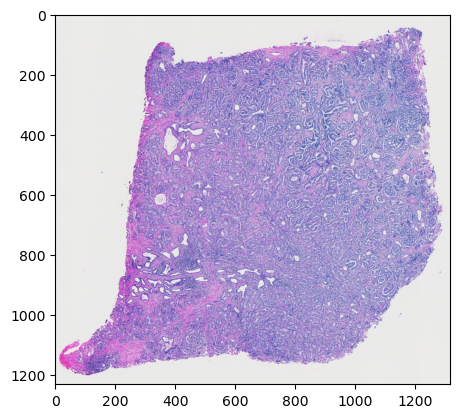

In [28]:
plt.imshow(x[::10, ::10]) # downsampling for faster visualization

#### Multiplex

In [29]:
multiplex_path = data_map[data_map['dtype']=='multiplex']['filepath'].iloc[0]
multiplex_path

'/diskmnt/primary/CODEX/HTAN/20240723_Prostate_serial_HT891Z1-S2H3Fp1_Codex1/HT891Z1-S2H3Fp1_U14__20240723.ome.tiff'

Reading in the file metadata

In [32]:
tf = tifffile.TiffFile(multiplex_path)
model = from_xml(tf.ome_metadata)
pixels = model.images[0].pixels
pixels

Pixels(
   id='Pixels:0',
   channels=[<25 field_type>],
   tiff_data_blocks=[{'plane_count': 25}],
   planes=[<25 field_type>],
   dimension_order='XYCZT',
   type='uint8',
   big_endian=False,
   size_x=13400,
   size_y=12263,
   size_z=1,
   size_c=25,
   size_t=1,
   physical_size_x=0.5100762527233116,
   physical_size_y=0.5100762527233116,
)

In [35]:
channel_order = [c.name for c in pixels.channels]
len(channel_order), channel_order

(25,
 ['DAPI',
  'CK14',
  'LYVE1',
  'CD4',
  'CK5',
  'STEAP4',
  'CD68',
  'E-Cadherin',
  'SMA (D)',
  'CD45(D)',
  'p63',
  'Pan-Cytokeratin',
  'HLA-DR',
  'Podoplanin',
  'Vimentin',
  'CD3e',
  'CD8',
  'CK7',
  'CD44',
  'Foxp3',
  'CD20',
  'Ki67',
  'AR',
  'AMACR',
  'CD31'])

Reading in the pixel level data for specific channels

In [36]:
channels = ['DAPI', 'Pan-Cytokeratin', 'Vimentin']
x = np.stack([
    tf.pages[channel_order.index(c)].asarray() for c in channels
])
x.shape # (c, h, w)

(3, 12263, 13400)

These functions allow us to visualize the multiplex data as pseudocolor images

In [37]:
def hex_to_rgb(
    hex_str: str # hex color
) -> np.ndarray:
    hex_str = hex_str.lstrip("#")
    x = np.asarray([int(hex_str[i:i+2], 16) for i in (0, 2, 4)]).astype(float)
    x /= 255
    return x

def to_pseudocolor(
    data: np.ndarray, # (C, H, W)
    view_settings: dict
) -> np.ndarray:
    """
    data - (c, h, w)
    view_settings - list of dicts that have the following fields:
        color - hex color for channel
        min_value - min value for channel
        max_value - max value for channel
        gamma - gamma value for channel
    """
    channels = [x['channel'] for x in view_settings]
    rgbs = np.stack([hex_to_rgb(x['color']) for x in view_settings])
    min_values = [x['min_value'] for x in view_settings]
    max_values = [x['max_value'] for x in view_settings]
    gammas = [x['gamma'] for x in view_settings]
        
    scaled = data / np.iinfo(data.dtype).max
    
    min_values = np.asarray(min_values) / np.iinfo(data.dtype).max
    max_values = np.asarray(max_values) / np.iinfo(data.dtype).max
    if gammas is not None:
        gammas = np.asarray(gammas)
        
    for i, val in enumerate(min_values):
        scaled[i][scaled[i] < val] = 0.
    for i, val in enumerate(max_values):
        scaled[i][scaled[i] > val] = val

    scaled -= scaled.min((1, 2), keepdims=True)
    scaled /= scaled.max((1, 2), keepdims=True)

    # gamma
    if gammas is not None:
        scaled **= rearrange(gammas, 'n -> n 1 1')

    scaled += 1e-16

    stacked = repeat(scaled, 'c h w -> c 3 h w ') * rearrange(rgbs, 'c n -> c n 1 1')

    rgb = rearrange(stacked.sum(0), 'c h w -> h w c')
    rgb[rgb>1] = 1.
    
    rgb *= 255.
    rgb = rgb.astype(np.uint8)
    
    return rgb

View settings for each channel contain the following

- channel - name of the channel
- color - hex string of the color to display channel as
- min_value - all pixel intensities below this value will be set to this value, range of the image values is usually 0-255
- max_value - all pixel intensities above this value will be set to this value, range of the image values is usually 0-255
- gamma - gamma contrast value

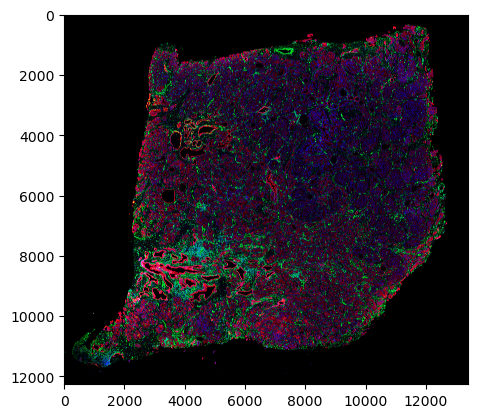

In [42]:
view_settings = [
    {
        'channel': 'DAPI',
        'color': '#0000ff',
        'min_value': 0,
        'max_value': 255,
        'gamma': 1.
    },
    {
        'channel': 'Pan-Cytokeratin',
        'color': '#ff0000',
        'min_value': 0,
        'max_value': 150,
        'gamma': 1.
    },
    {
        'channel': 'Vimentin',
        'color': '#00ff00',
        'min_value': 0,
        'max_value': 150,
        'gamma': 1.
    },
]

rgb = to_pseudocolor(x, view_settings)
plt.imshow(rgb)

## xenium